# SigLIP VLM – RSNA Pneumonia Detection

SigLIP (Sigmoid Loss for Language-Image Pre-training) is a vision-language model from Google.
We use its vision encoder as a feature extractor and attach a binary classification head.
Model: `google/siglip-base-patch16-224` from HuggingFace Transformers.


In [8]:
# Install transformers if not already present (Kaggle has it pre-installed)
# !pip install transformers -q

In [9]:
import os, cv2, pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from transformers import AutoProcessor, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

In [10]:
TRAIN_IMG_DIR = "/kaggle/input/competitions/rsna-pneumonia-detection-challenge/stage_2_train_images"
CSV_PATH      = "/kaggle/input/competitions/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

train_df = pd.read_csv(CSV_PATH)
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 18678 Val: 4003 Test: 4003


In [11]:
# ── SigLIP processor handles resizing internally (224x224) ────
MODEL_NAME = "google/siglip-base-patch16-224"
processor  = AutoProcessor.from_pretrained(MODEL_NAME)

class RSNADataset(Dataset):
    """Returns processor-ready pixel_values tensors."""
    def __init__(self, df, img_dir, processor):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid   = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]
        dcm   = pydicom.dcmread(os.path.join(self.img_dir, pid + ".dcm"))
        arr   = cv2.normalize(dcm.pixel_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img   = Image.fromarray(arr).convert("RGB")
        # Processor resizes to 224x224 and normalises with SigLIP stats
        inputs = self.processor(images=img, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3,224,224)
        return pixel_values, torch.tensor(label, dtype=torch.float32)

In [12]:
BATCH_SIZE = 16   # SigLIP ViT-B is heavier; lower batch if OOM
train_loader = DataLoader(RSNADataset(train_df, TRAIN_IMG_DIR, processor), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(RSNADataset(val_df,   TRAIN_IMG_DIR, processor), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(RSNADataset(test_df,  TRAIN_IMG_DIR, processor), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [13]:
# ── SigLIP Vision Encoder + Classification Head ───────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SigLIPClassifier(nn.Module):
    def __init__(self, model_name, num_classes=1):
        super().__init__()
        base = AutoModel.from_pretrained(model_name)
        # Use only the vision model component
        self.vision_model = base.vision_model
        hidden_size = self.vision_model.config.hidden_size  # 768 for base
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, pixel_values):
        # pooler_output is the [CLS] token representation
        outputs = self.vision_model(pixel_values=pixel_values)
        pooled  = outputs.pooler_output          # (B, hidden_size)
        return self.classifier(pooled)           # (B, 1)

model = SigLIPClassifier(MODEL_NAME).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  # smaller LR for VLM

Loading weights:   0%|          | 0/408 [00:00<?, ?it/s]

In [14]:
EPOCHS    = 40
PATIENCE  = 5
THRESHOLD = 0.5
MODEL_SAVE = "best_siglip.pth"

history = {k: [] for k in
    ["train_loss","val_loss","train_acc","val_acc",
     "train_prec","val_prec","train_f1","val_f1",
     "train_auc","val_auc"]}

best_loss, patience_ctr = float("inf"), 0

def compute_metrics(y_true, y_prob):
    y_pred = (y_prob > THRESHOLD).astype(int)
    return accuracy_score(y_true, y_pred), \
           precision_score(y_true, y_pred, zero_division=0), \
           f1_score(y_true, y_pred, zero_division=0), \
           roc_auc_score(y_true, y_prob)

for epoch in range(EPOCHS):
    model.train()
    t_loss, t_probs, t_labels = [], [], []
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        logits = model(x)
        loss   = criterion(logits, y)
        loss.backward(); optimizer.step()
        t_loss.append(loss.item())
        t_probs.append(torch.sigmoid(logits).detach().cpu())
        t_labels.append(y.cpu())
    t_probs  = torch.cat(t_probs).numpy()
    t_labels = torch.cat(t_labels).numpy()

    model.eval()
    v_loss, v_probs, v_labels = [], [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x, y = x.to(device), y.to(device).unsqueeze(1)
            logits = model(x)
            v_loss.append(criterion(logits, y).item())
            v_probs.append(torch.sigmoid(logits).cpu())
            v_labels.append(y.cpu())
    v_probs  = torch.cat(v_probs).numpy()
    v_labels = torch.cat(v_labels).numpy()

    t_acc,t_prec,t_f1,t_auc = compute_metrics(t_labels,t_probs)
    v_acc,v_prec,v_f1,v_auc = compute_metrics(v_labels,v_probs)

    for key,val in zip(history.keys(),
        [np.mean(t_loss),np.mean(v_loss),t_acc,v_acc,
         t_prec,v_prec,t_f1,v_f1,t_auc,v_auc]):
        history[key].append(val)

    print(f"Epoch {epoch+1} | Train Loss {np.mean(t_loss):.5f} | Val Loss {np.mean(v_loss):.5f} | Val AUC {v_auc:.5f}")

    if np.mean(v_loss) < best_loss:
        best_loss=np.mean(v_loss); patience_ctr=0
        torch.save(model.state_dict(), MODEL_SAVE)
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping"); break

Epoch 1 [Val]: 100%|██████████| 251/251 [01:03<00:00,  3.93it/s]


Epoch 1 | Train Loss 0.39309 | Val Loss 0.36446 | Val AUC 0.86440


Epoch 2 [Val]: 100%|██████████| 251/251 [00:47<00:00,  5.24it/s]


Epoch 2 | Train Loss 0.33267 | Val Loss 0.35632 | Val AUC 0.87181


Epoch 3 [Val]: 100%|██████████| 251/251 [00:47<00:00,  5.28it/s]


Epoch 3 | Train Loss 0.25133 | Val Loss 0.38842 | Val AUC 0.86490


Epoch 4 [Val]: 100%|██████████| 251/251 [00:48<00:00,  5.22it/s]


Epoch 4 | Train Loss 0.15018 | Val Loss 0.48131 | Val AUC 0.85482


Epoch 5 [Val]: 100%|██████████| 251/251 [00:47<00:00,  5.29it/s]


Epoch 5 | Train Loss 0.08157 | Val Loss 0.83197 | Val AUC 0.85336


Epoch 6 [Val]: 100%|██████████| 251/251 [00:47<00:00,  5.32it/s]


Epoch 6 | Train Loss 0.05202 | Val Loss 0.68278 | Val AUC 0.84707


Epoch 7 [Val]: 100%|██████████| 251/251 [00:47<00:00,  5.27it/s]

Epoch 7 | Train Loss 0.03735 | Val Loss 0.77931 | Val AUC 0.85137
Early stopping


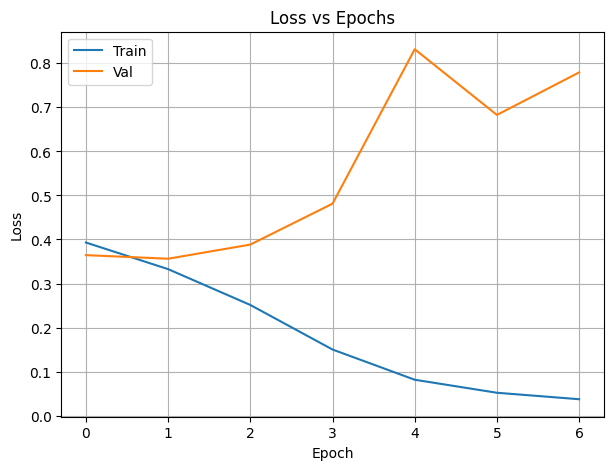

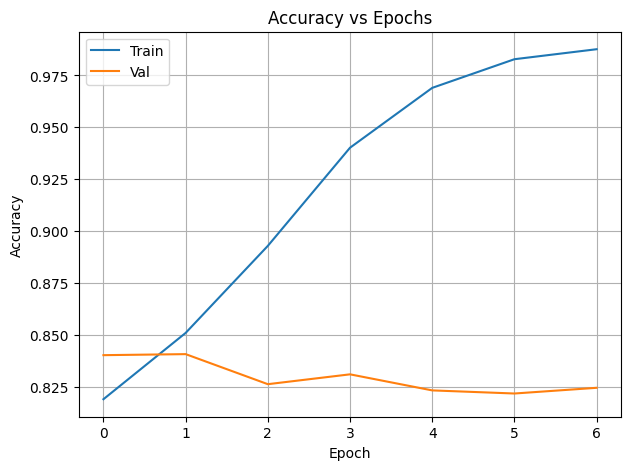

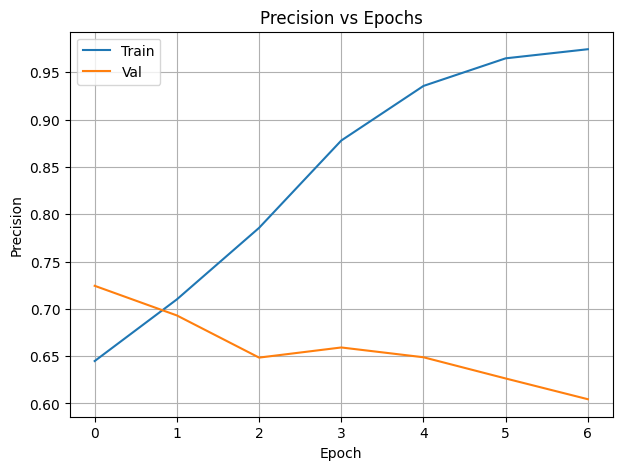

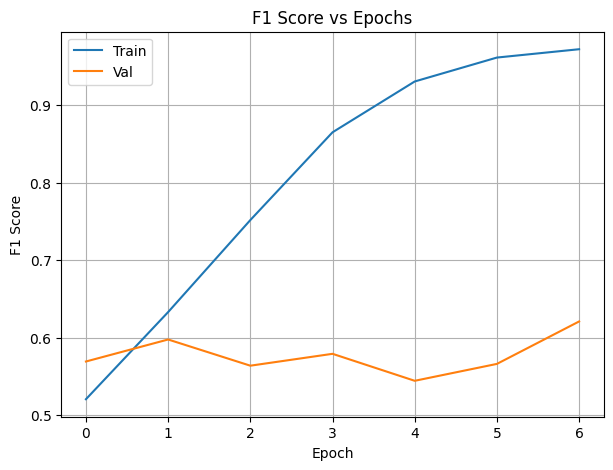

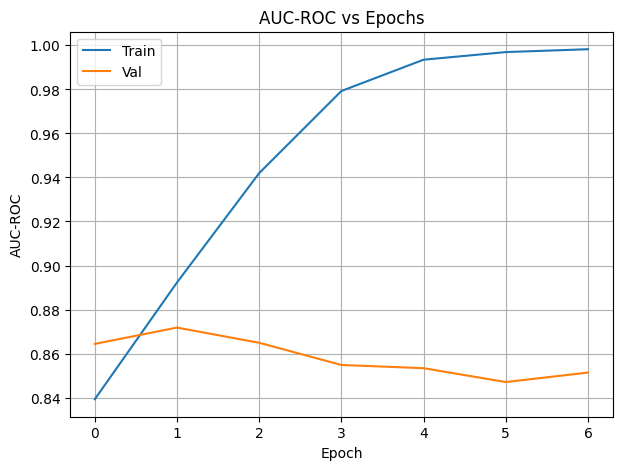

In [15]:
def plot_metric(name, ylabel):
    plt.figure(figsize=(7,5))
    plt.plot(history[f"train_{name}"], label="Train")
    plt.plot(history[f"val_{name}"],   label="Val")
    plt.xlabel("Epoch"); plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Epochs"); plt.legend(); plt.grid(); plt.show()

for m,l in [("loss","Loss"),("acc","Accuracy"),("prec","Precision"),("f1","F1 Score"),("auc","AUC-ROC")]:
    plot_metric(m,l)

              precision    recall  f1-score   support

         0.0    0.88061   0.93002   0.90464      3101
         1.0    0.70192   0.56652   0.62699       902

    accuracy                        0.84811      4003
   macro avg    0.79127   0.74827   0.76582      4003
weighted avg    0.84035   0.84811   0.84208      4003



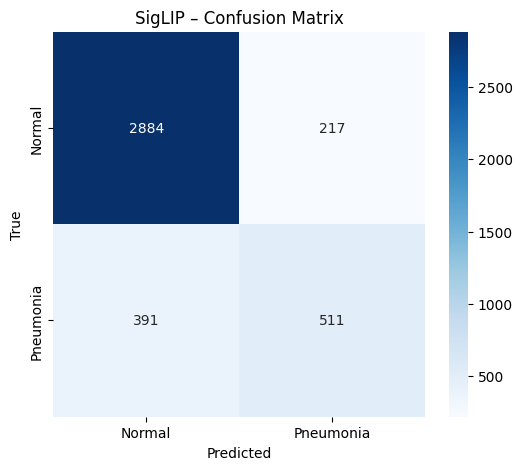

In [16]:
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()
probs, labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        probs.append(torch.sigmoid(model(x.to(device))).cpu())
        labels.append(y.unsqueeze(1))
probs  = torch.cat(probs).numpy()
labels = torch.cat(labels).numpy()
preds  = (probs > THRESHOLD).astype(int)
print(classification_report(labels, preds, digits=5))
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])
plt.title("SigLIP – Confusion Matrix")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.show()